<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задачи" data-toc-modified-id="Задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задачи</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выгрузка-из-базы-данных" data-toc-modified-id="Выгрузка-из-базы-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выгрузка из базы данных</a></span></li><li><span><a href="#Типы-переменных" data-toc-modified-id="Типы-переменных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Типы переменных</a></span></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Пропуски</a></span></li><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Дубликаты</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Посмотрим-основные-статистики-признаков" data-toc-modified-id="Посмотрим-основные-статистики-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Посмотрим основные статистики признаков</a></span></li><li><span><a href="#Посмотрим-на-распределения-наших-признаков" data-toc-modified-id="Посмотрим-на-распределения-наших-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Посмотрим на распределения наших признаков</a></span></li></ul></li><li><span><a href="#Сегментирование-с-помощью-RFM-Score" data-toc-modified-id="Сегментирование-с-помощью-RFM-Score-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сегментирование с помощью RFM-Score</a></span><ul class="toc-item"><li><span><a href="#Признак-Recency" data-toc-modified-id="Признак-Recency-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Признак Recency</a></span></li><li><span><a href="#Признак-Frequency" data-toc-modified-id="Признак-Frequency-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Признак Frequency</a></span></li><li><span><a href="#Признак-Monetary" data-toc-modified-id="Признак-Monetary-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Признак Monetary</a></span></li><li><span><a href="#Считаем-RFM-Score" data-toc-modified-id="Считаем-RFM-Score-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Считаем RFM-Score</a></span></li><li><span><a href="#Сегменты-на-основе-RFM-Score" data-toc-modified-id="Сегменты-на-основе-RFM-Score-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Сегменты на основе RFM-Score</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Сегментирование клиентов онлайн магазина

Есть ограниченный бюджет для проведения рекламной компании. Для экономии бюджета и увеличения эффективности компании, требуется выделить сегменты клииентов, наиболее лояльных к нашему онлайн магазину, на которых и будет нацелена рекламная компания

## Задачи

- Выгрузить необходимые данные из БД
- Провести RFM анализ и на его основе выделить сегменты клиентов, на которые будет нацелена рекламная компания

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

plt.style.use('bmh')

### Выгрузка из базы данных

Данные находятся в БД. Подключимся к ней

In [2]:
db_config = {
    'user': os.environ.get('BD_USER'),
    'pwd': os.environ.get('BD_PASS'),
    'host': 'localhost',
    'db': 'postgres'
}

connection_string = f'postgresql://{db_config["user"]}:{db_config["pwd"]}@{db_config["host"]}/{db_config["db"]}'
engine = create_engine(connection_string)

Напишем функцию, которая будет принимать запрос PostgreSQL в формате строки и возвращать результат

In [3]:
def sql(query):
    return pd.io.sql.read_sql(query, con=engine)

Сделаем запрос к БД, где посмотрим имеющиеся таблицы у схемы `online_store`

In [4]:
query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'online_store'
"""

sql(query)

,table_name
0,costs
1,events
2,orders
3,profiles
4,sessions


Нам понадобится только таблица `orders` с информацией о заказах. Посмотрим на таблицу

In [5]:
query = """
    SELECT *
    FROM online_store.orders
    LIMIT 5;
"""

sql(query)

,user_id,event_dt,revenue
0,55519067947,2020-06-14,5.62
1,831753022495,2020-06-14,1.33
2,284598472478,2020-06-14,4.93
3,725363192554,2020-06-14,1.55
4,324356134597,2020-06-14,9.60


Посмотрим, данными за какой период мы обладаем

In [6]:
query = """
    SELECT min(event_dt), max(event_dt), 
           max(event_dt) - min(event_dt) as observation_days
    FROM online_store.orders
    LIMIT 5;
"""

sql(query)

,min,max,observation_days
0,2020-06-14,2020-06-27,13


Всего у нас имеются данные о заказах за 13 дней. Теперь расчитаем следующие признаки для каждого пользователя:
- `orders_count` - количество заказов
- `total_revenue` - суммарная выручка
- `last_order_days` - количество дней, прошедших с последнего заказа

In [7]:
query = """
    SELECT user_id, 
           count(event_dt) as orders_count,
           sum(revenue) as total_revenue,
           '2020-06-28'::date - max(event_dt) as last_order_days
    FROM online_store.orders o
    GROUP BY user_id
"""

df = sql(query)

In [8]:
df.head()

,user_id,orders_count,total_revenue,last_order_days
0,624473479767,4,16.19,6
1,809129819459,4,18.67,1
2,759335137750,1,1.93,6
3,375025211218,1,9.93,7
4,710396084609,2,14.89,8


### Типы переменных

Посмотрим типы переменных в таблице

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13065 entries, 0 to 13064
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          13065 non-null  int64  
 1   orders_count     13065 non-null  int64  
 2   total_revenue    13065 non-null  float64
 3   last_order_days  13065 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 408.4 KB


Все типы соответствуют смыслу переменных

### Пропуски

In [10]:
df.isna().sum()

user_id            0
orders_count       0
total_revenue      0
last_order_days    0
dtype: int64

Пропуски отсутствуют

### Дубликаты

In [11]:
df.duplicated().sum()

0

Дубликаты отсутствуют

## Исследовательский анализ

### Посмотрим основные статистики признаков

In [12]:
df.describe()

,user_id,orders_count,total_revenue,last_order_days
count,1.306500e+04,13065.000000,13065.000000,13065.000000
mean,5.011387e+11,1.620130,8.910493,5.521929
std,2.889184e+11,0.894706,5.958759,3.653404
min,1.096401e+07,1.000000,1.000000,1.000000
25%,2.515377e+11,1.000000,4.660000,2.000000
50%,4.999394e+11,1.000000,7.820000,5.000000
75%,7.515865e+11,2.000000,11.550000,9.000000
max,9.999298e+11,8.000000,52.820000,14.000000


Имеем данные о заказах 13065 уникальных клиентов

### Посмотрим на распределения наших признаков

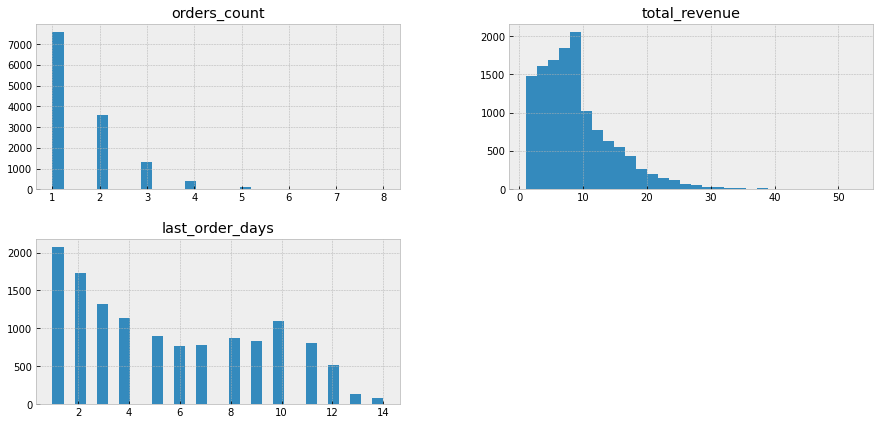

In [13]:
df.iloc[::, 1:].hist(figsize=(15, 7), bins=30)
plt.show()

На графиках видим частотные распределения трех наших признаков. Признаки `orders_count` и `last_orders_days` имеют дискретные распределения, признак `total_revenue` непрерывное

## Сегментирование с помощью RFM-Score

Расшифруем аббревиатуру RFM:
- `R` - recency или насколько недавно клиент делал заказ 
- `F` - frequency или как часто клиент делал заказ 
- `M` - monetary или как много денег (в нашем случае будем использовать просто выручку) принес нам клиент

Теперь создадим соответствующие признаки. Каждый признак будет принимать значения 1-4, где 1 это наихудший результат, соответственно далее идут более лучшие исходы

### Признак Recency

In [14]:
df['recency'] = 5 - (pd.qcut(df['last_order_days'], 4, labels=False) + 1)

In [15]:
df.groupby('recency').agg({'last_order_days': ['mean', 'count']})

last_order_days      
                   mean count
recency                      
1             10.982244  2647
2              7.545427  3247
3              3.873478  3367
4              1.454259  3804

### Признак Frequency

In [16]:
pd.qcut(df['orders_count'], 4, labels=False, duplicates='drop').value_counts()

0    11191
1     1874
Name: orders_count, dtype: int64

Как мы могли видеть на гистограмме признака `orders_count` - это дискретная переменная, где большинство значений это 1. Из-за этого функция qcut не может поделить наши наблюдения на равные отрезки. Поэтому просто напишем свою функцию деления

In [17]:
def freq(f):
    if f == 1:
        return 1
    if f == 2:
        return 2
    if f == 3:
        return 3
    if f <= 8:
        return 4

In [18]:
df['frequency'] = df['orders_count'].apply(freq)

Посмотрим на количество наблюдений в каждом сегменте `frequency`

In [19]:
df.groupby('frequency').agg({'orders_count': ['mean', 'count']})

orders_count      
                  mean count
frequency                   
1             1.000000  7610
2             2.000000  3581
3             3.000000  1311
4             4.373002   563

### Признак Monetary

In [20]:
df['monetary'] = (pd.qcut(df['total_revenue'], 4, labels=False) + 1)

In [21]:
df.groupby('monetary').agg({'total_revenue': ['mean']})

,total_revenue
,mean
monetary,
1,2.864222
2,6.277532
3,9.302560
4,17.203690


### Считаем RFM-Score

Теперь для каждого пользователя сложим все три признака R+F+M и разделим на 3

In [22]:
df['rfm'] = (df['recency'] + df['frequency'] + df['monetary']) / 3

In [23]:
df.head()

,user_id,orders_count,total_revenue,last_order_days,recency,frequency,monetary,rfm
0,624473479767,4,16.19,6,2,4,4,3.333333
1,809129819459,4,18.67,1,4,4,4,4.000000
2,759335137750,1,1.93,6,2,1,1,1.333333
3,375025211218,1,9.93,7,2,1,3,2.000000
4,710396084609,2,14.89,8,2,2,4,2.666667


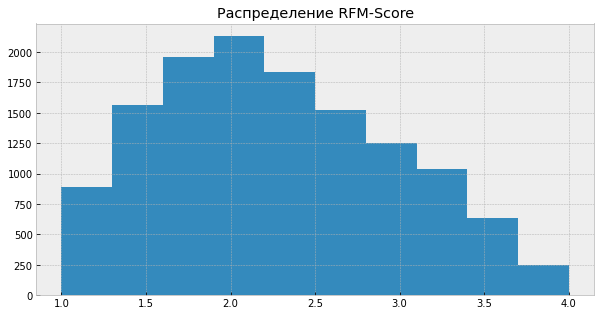

In [24]:
df['rfm'].hist(figsize=(10, 5))
plt.title('Распределение RFM-Score')
plt.show()

In [25]:
df['rfm'].agg(['mean', 'median'])

mean      2.247021
median    2.000000
Name: rfm, dtype: float64

График немного смещен в левую, сторону

### Сегменты на основе RFM-Score

Теперь округлим RFM-Score до ближайшего целого числа, в результате получим 4 сегмента пользователей

In [26]:
df['segment'] = df['rfm'].round().astype('int')

In [27]:
df.head()

,user_id,orders_count,total_revenue,last_order_days,recency,frequency,monetary,rfm,segment
0,624473479767,4,16.19,6,2,4,4,3.333333,3
1,809129819459,4,18.67,1,4,4,4,4.000000,4
2,759335137750,1,1.93,6,2,1,1,1.333333,1
3,375025211218,1,9.93,7,2,1,3,2.000000,2
4,710396084609,2,14.89,8,2,2,4,2.666667,3


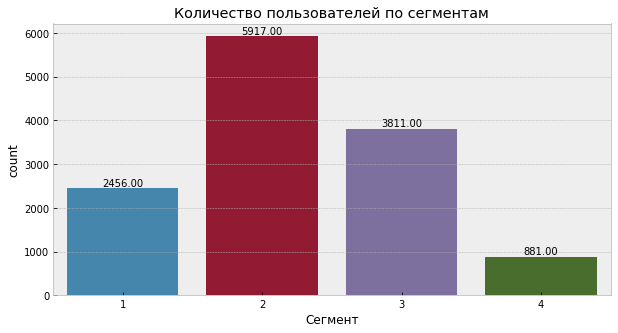

In [28]:
plt.figure(figsize=(10, 5))
fig = sns.countplot(x='segment', data=df)
plt.title('Количество пользователей по сегментам')
plt.xlabel('Сегмент')
plt.bar_label(fig.containers[0], fmt='%.2f')
plt.show()

Посмотрим на средние показатели выделенных сегментов

In [29]:
df.groupby('segment').agg({
    'total_revenue': 'mean', 
    'last_order_days': 'mean', 
    'orders_count': 'mean',
    'user_id': 'nunique'
})

,total_revenue,last_order_days,orders_count,user_id
segment,,,,
1,3.875680,9.941368,1.004479,2456
2,6.516265,5.374345,1.202129,5917
3,13.025712,3.723695,2.180792,3811
4,21.224960,1.971623,3.718502,881


Рассчитаем количество и долю клиентов в 3 и 4 сегменте

In [30]:
segment3_4_len = len(df[(df['segment'] == 3) | (df['segment'] == 4)])
segment3_4_len

4692

In [31]:
round(segment3_4_len / len(df), 2)

0.36

## Вывод
- Разделили клиентов на 4 сегмента, в зависимости от их RFM-Score
- 3 и 4 сегменты,включают 4692 клиента, или около 36% от общего количества клиентов
- На клиентов из данных сегментов и рекомендуется таргетировать рекламную компанию